# Modeling Time Series Problems using LSTMs

Made for the Data Science Workshop 2018 (African Institute for Mathematical Sciences)

Extended from (https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

# Keras imports
from keras.models import Sequential
from keras.layers import Dense

# Here we import the LSTM cell which allows us to make LSTM cells
# Here is the documentation for the LSTM cell in Keras https://keras.io/layers/recurrent/#lstm
from keras.layers import LSTM

Using TensorFlow backend.


## Read dataset

In [2]:
# Read in the data using Pandas
dataframe = pd.read_csv('carbondata_clean.csv', engine= 'python', sep=';', header=None)

# Labels the columns manually
dataframe.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Store the dataset into a numpy array
dataset = dataframe.values
dataset = dataset.astype('float32')

### Print the shape of the dataset

In [3]:
dataset.shape

(53, 12)

### Display the dataset

In [4]:
dataframe.head()


,1,2,3,4,5,6,7,8,9,10,11,12
0,315.62,316.38,316.71,317.72,318.29,318.15,316.54,314.80,313.84,313.26,314.80,315.58
1,316.43,316.97,317.58,319.02,320.03,319.59,318.18,315.91,314.16,313.83,315.00,316.19
2,316.93,317.70,318.54,319.48,320.58,319.77,318.57,316.79,314.80,315.38,316.10,317.01
3,317.94,318.56,319.68,320.63,321.01,320.55,319.58,317.40,316.26,315.42,316.69,317.69
4,318.74,319.08,319.86,321.39,322.25,321.47,319.74,317.77,316.21,315.99,317.12,318.31


## Take a look at the numpy dataset

In [5]:
dataset.shape

(53, 12)

## Reshape the data into a long vector

In [6]:
dataset_vector = dataset.reshape(-1,1)

In [7]:
dataset_vector.shape

(636, 1)

## Plot all the data

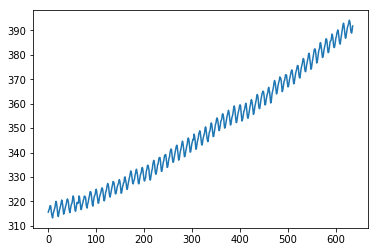

In [8]:
plt.plot(dataset_vector[0:])
plt.show()

## Take a look at data for 1 year (1959)

In [9]:
# 12 data points
len(dataset_vector[1:13])

12

In [10]:
dataset_vector[1:13]

array([[316.38],
       [316.71],
       [317.72],
       [318.29],
       [318.15],
       [316.54],
       [314.8 ],
       [313.84],
       [313.26],
       [314.8 ],
       [315.58],
       [316.43]], dtype=float32)

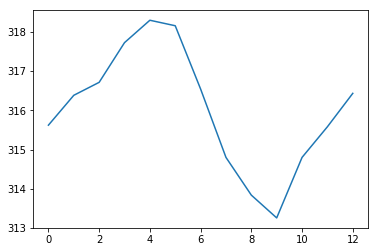

In [11]:
# Now do the plotting
plt.plot(dataset_vector[0:13])
plt.show()

## Normalise

Normalise the data so that all the values are between 0 and 1. Here we make use of ScikitLearn's MinMaxScaler() function. There are alternatives. Here is a link to various pre-processing steps that you can use: http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

In [12]:
# Take a look at the values before applying the normalisation
dataset_vector[0:5]

array([[315.62],
       [316.38],
       [316.71],
       [317.72],
       [318.29]], dtype=float32)

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_vector = scaler.fit_transform(dataset_vector)

In [14]:
# Now look at the values after applying the normalisation (Note: it's always a good idea to print 
# your data often to the screen so you can check what's going on. This way you can easily catch mistakes
# at an early stage).
dataset_vector[0:5]

array([[0.02917171],
       [0.03856611],
       [0.04264498],
       [0.05512977],
       [0.06217551]], dtype=float32)

## Train/test split

It's not a good idea to train your model on just your training data because then you cannot check it's performance on data that it has never seen before. A good idea is to split your data into at least a training and testing set.

"Training Dataset: The sample of data used to fit the model."

"Test Dataset: The sample of data used to provide an <b>unbiased evaluation</b> of a final model fit on the training dataset."

You can read more about this here: https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

<b> Question: do you think it would be a good idea to shuffle this data? (hint: think about what the data actually is, what is the data about?) </b>

In [15]:
# Define the amount of data that will be used for training. This is a slightly different approach to using Scikit
# learn's built in function train_test_split. Here we are the splitting manually. It might be a good idea to try re
# write this code to use scikit learn's function.
train_size = int(len(dataset_vector) * 0.67)

# Define the amount of data that will be used for testing (total length minus the amount of training data).
test_size = len(dataset_vector) - train_size

# Split the data manually (note that here we are not shuffling the data)
train, test = dataset_vector[0:train_size,:], dataset_vector[train_size:len(dataset_vector),:]

### Create the labels for the dataset

As it stands, the dataset does not have labels (targets) - i.e. the things you want to predict. The dataset just has values of the carbon emission for each month across multiple years. We need to create our predictions manually by shifting the data. 

<b> Note: </b>

The function <i>create_dataset</i> shifts the data in such a way that we can create features and targets. This will make sense in the figures below.

In [16]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
train[0:2]

array([[0.02917171],
       [0.03856611]], dtype=float32)

In [18]:
look_back = 12

# Split the data into training features and training targets
trainX, trainY = create_dataset(train, look_back)

# Split the data into testing features and testing targets
testX, testY = create_dataset(test, look_back)

### Print out the shape of the data

Always a good idea to print the shapes to make sure that everything worked well.

In [19]:
print('Train X shape ',trainX.shape)
print('Train Y shape',trainY.shape)
print('Test X shape ',testX.shape)
print('Test Y shape ',testY.shape)

Train X shape  (413, 12)
Train Y shape (413,)
Test X shape  (197, 12)
Test Y shape  (197,)


## Things will start making sense from here onwards

In [20]:
dataframe.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,315.62,316.38,316.71,317.72,318.29,318.15,316.54,314.80,313.84,313.26,314.80,315.58
1,316.43,316.97,317.58,319.02,320.03,319.59,318.18,315.91,314.16,313.83,315.00,316.19
2,316.93,317.70,318.54,319.48,320.58,319.77,318.57,316.79,314.80,315.38,316.10,317.01
3,317.94,318.56,319.68,320.63,321.01,320.55,319.58,317.40,316.26,315.42,316.69,317.69
4,318.74,319.08,319.86,321.39,322.25,321.47,319.74,317.77,316.21,315.99,317.12,318.31


### Here is training example 1. 

Double (red) lines shows the 12 training examples, and the single (blue) line shows the 1 test example.

Here of values are not normalised.

<img src="example1.png">

### Here is training example 2. 

Double (red) lines shows the 12 training examples, and the single (blue) line shows the 1 test example.

Here of values are not normalised.

<i> Can you notice how the lines have shifted? This is how we construct training and test data for time-series problems. </i>

<img src="example2.png">

## We can also check this in numpy.

You can verify the first and second training examples to the 14 first points in the vector below.

First take the look at the first 14 points in the normalised dataset. We will reference to this to show you how the training and testing data was constructed.

In [21]:
dataset_vector[0:14]

array([[0.02917171],
       [0.03856611],
       [0.04264498],
       [0.05512977],
       [0.06217551],
       [0.06044483],
       [0.04054403],
       [0.01903558],
       [0.00716925],
       [0.        ],
       [0.01903558],
       [0.02867723],
       [0.03918409],
       [0.0458591 ]], dtype=float32)

The first training example was the first 12 data points

In [22]:
trainX[0]

array([0.02917171, 0.03856611, 0.04264498, 0.05512977, 0.06217551,
       0.06044483, 0.04054403, 0.01903558, 0.00716925, 0.        ,
       0.01903558, 0.02867723], dtype=float32)

The test example is actually the 13th month (i.e. the first month in the 2nd year)

In [23]:
trainY[0]

0.039184093

The second training example is the 2nd month to the 13th month <b>(can you see how we shifted everything by 1 time step) </b>

In [24]:
trainX[1]

array([0.03856611, 0.04264498, 0.05512977, 0.06217551, 0.06044483,
       0.04054403, 0.01903558, 0.00716925, 0.        , 0.01903558,
       0.02867723, 0.03918409], dtype=float32)

The second testing example is the 14th month (i.e. the second month in the 2nd year).

In [25]:
trainY[1]

0.0458591

## Reshape to [samples, timesteps, features]

We need to reshape the data into [samples, timesteps, features] as this is what Keras expects.

Samples denotes each example. (e.g. we have 413 training examples and 197 test examples)

Time steps denotes each time step for each of the points. In our case we have 12 time steps.

It is possible that you have multiple features at each time step. In our dataset we just a single carbon emission feature at each time step hence we use a value of one.

In [26]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Check that the numpy reshape function actually did what we wanted.

Here we want [samples, timesteps, features]. And indeed the output for training is (413, 12, 1) whereby we have 413 training samples, 12 time steps for each point, and there is only 1 feature per time step.

In [27]:
print('Train X shape ',trainX.shape)
print('Train Y shape',trainY.shape)
print('Test X shape ',testX.shape)
print('Test Y shape ',testY.shape)

Train X shape  (413, 12, 1)
Train Y shape (413,)
Test X shape  (197, 12, 1)
Test Y shape  (197,)


# Now it's time to make the LSTM models!

<hr>

## Create a (stateless) LSTM model

Here is where we create the LSTM model in Keras

In [28]:
# Define the model in Keras
model = Sequential()

# This is how we add an LSTM cell. (We can stack multiple cells on top of each other by repeating this line)
model.add(LSTM(8, batch_input_shape=(None, 12, 1), stateful=False))

# We have to add a fully connected layer of the LSTM to output the predictions. Here we only have 1 node because
# our time-series prediction is expecting one output. 
model.add(Dense(1))

# We define our loss function. Here since we are dealing with numerical data, one option is to use mean squared error.
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
# Check the number of parameters. Always a good idea to take a look at the model from Keras' point of view
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


### Start training the model

We need to specify a few things:

<li> training features
<li> training targets
<li> number of epochs
<li> batch size

We also mention the verbose which denotes how much we are outputing to the screen during the training process

In [30]:
model.fit(trainX, trainY, epochs=15, batch_size=10, verbose = 2, shuffle=False)

Epoch 1/15
 - 3s - loss: 0.0042
Epoch 2/15
 - 1s - loss: 0.0147
Epoch 3/15
 - 1s - loss: 0.0057
Epoch 4/15
 - 1s - loss: 0.0022
Epoch 5/15
 - 1s - loss: 0.0011
Epoch 6/15
 - 1s - loss: 8.9307e-04
Epoch 7/15
 - 1s - loss: 8.7283e-04
Epoch 8/15
 - 1s - loss: 8.7113e-04
Epoch 9/15
 - 1s - loss: 8.6866e-04
Epoch 10/15
 - 1s - loss: 8.6383e-04
Epoch 11/15
 - 1s - loss: 8.5713e-04
Epoch 12/15
 - 1s - loss: 8.4959e-04
Epoch 13/15
 - 1s - loss: 8.4169e-04
Epoch 14/15
 - 1s - loss: 8.3367e-04
Epoch 15/15
 - 1s - loss: 8.2575e-04


## Predict on the test data and prepare the data for plotting

In [31]:
batch_size=10
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
model.reset_states()
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))

testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
model.reset_states()
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))

# generate predictions for training
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_vector)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_vector)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset_vector)-1, :] = testPredict

## Plot the predictions and the correct targets

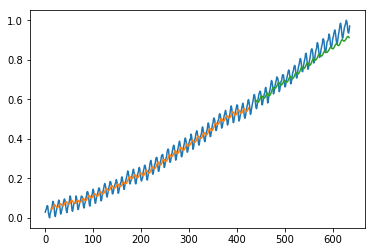

In [32]:
plt.plot(dataset_vector)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<hr>

# Stateful model

In the stateless LSTM configuration, <b>internal state is reset after each training batch</b> or each batch when making predictions.

In [33]:
# Define the model in Keras
model = Sequential()

In [34]:
# This is how we add an LSTM cell. (We can stack multiple cells on top of each other by repeating this line)
model.add(LSTM(8, batch_input_shape=(1, 12, 1), stateful=True))

In [35]:
# We have to add a fully connected layer of the LSTM to output the predictions. Here we only have 1 node because
# our time-series prediction is expecting one output. 
model.add(Dense(1))

In [36]:
# We define our loss function. Here since we are dealing with numerical data, one option is to use mean squared error.
model.compile(loss='mean_squared_error', optimizer='adam')

In [37]:
# Check the number of parameters. Always a good idea to take a look at the model from Keras' point of view
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 8)                    320       
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


## Training is done slightly differently for a stateful model

A number of points:

<li>Here we have a for loop.

<li>In each iteration of the for loop we fit the model on a number of epochs, in this case 1 epoch per iteration.

<li>After each fitting of the model on the epochs, we reset the cell states by calling the reset_states() function. 

<li>Remember that in a stateless model the cell states are reset after each training batch. So here we keep the cell states between batches.

In [38]:
for i in range(10):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()
# Estimate model performance

Epoch 1/1
 - 8s - loss: 0.0011
Epoch 1/1
 - 6s - loss: 0.0021
Epoch 1/1
 - 6s - loss: 0.0015
Epoch 1/1
 - 7s - loss: 0.0012
Epoch 1/1
 - 7s - loss: 0.0010
Epoch 1/1
 - 6s - loss: 9.4587e-04
Epoch 1/1
 - 7s - loss: 9.0576e-04
Epoch 1/1
 - 7s - loss: 8.7854e-04
Epoch 1/1
 - 7s - loss: 8.5559e-04
Epoch 1/1
 - 11s - loss: 8.3413e-04


## Predict on the test data and prepare the data for plotting

In [39]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, batch_size=1, verbose=0)
model.reset_states()
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(np.array([[trainScore]]))

testScore = model.evaluate(testX, testY, batch_size=1, verbose=0)
model.reset_states()
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(np.array([[testScore]]))

# generate predictions for training
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_vector)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_vector)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset_vector)-1, :] = testPredict

## Plot the predictions and the correct targets

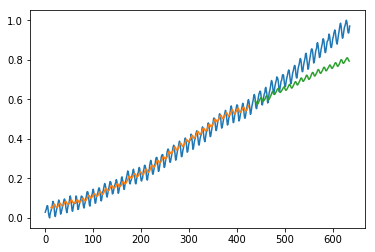

In [40]:
plt.plot(dataset_vector)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

<hr>

### Hyper-parameters

There are a few tips on how to tune the hyper-parameters for LSTMs here: https://deeplearning4j.org/lstm.html#tuning Note that those tips contain information about another programming library (DL4J), however everything they refer to has equivalents in Keras.

In [41]:
dataframe = pd.read_csv('Hourly_scaled_data_2011_12.csv', engine= 'python')

In [42]:
dataframe.head()

,WS_62_mean,WS_40_mean,WS_20_mean,WS_10_mean,WD_60_mean,WD_20_mean,Tair_mean,Tgrad_mean,Pbaro_mean,RH_mean,WS_60_mean
0,0.262530,0.261919,0.134473,0.001165,-2.306711,2.005896,-0.033966,-0.452485,-0.126758,1.063844,0.296444
1,0.671738,0.712974,0.616906,0.494429,-2.316548,2.023062,-0.029837,-0.453142,-0.170394,1.137144,0.704231
2,0.383313,0.403471,0.343874,0.291723,1.850710,1.838378,-0.079384,-0.456427,-0.279494,1.160050,0.409122
3,0.698776,0.729941,0.577902,0.386307,1.465410,1.312413,0.228220,0.803476,-0.246765,0.674442,0.695297
4,-0.532456,-0.505240,-0.571279,-0.662186,1.921305,1.907377,-0.118608,-0.384826,-0.214036,1.219605,-0.504841


In [43]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [44]:
train = (dataframe.values[0:10000,-1])

In [45]:
train = train.reshape(-1,1)

In [46]:
np.shape(train)

(10000, 1)

In [47]:
look_back = 2

# Split the data into training features and training targets
trainX, trainY = create_dataset(train, look_back)

# Split the data into testing features and testing targets
#testX, testY = create_dataset(test, look_back)

In [48]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [49]:
np.shape(trainX)

(9997, 2, 1)

In [50]:
np.shape(trainY)

(9997,)

In [51]:
#trainX[0:2]

In [52]:
batch_size = 24

In [53]:
# Define the model in Keras
model = Sequential()

# This is how we add an LSTM cell. (We can stack multiple cells on top of each other by repeating this line)
model.add(LSTM(310, batch_input_shape=(batch_size, look_back, 1), stateful=True))
# We have to add a fully connected layer of the LSTM to output the predictions. Here we only have 1 node because
# our time-series prediction is expecting one output. 
model.add(Dense(1))

# We define our loss function. Here since we are dealing with numerical data, one option is to use mean squared error.
model.compile(loss='mean_squared_error', optimizer='adam')

In [54]:
# Check the number of parameters. Always a good idea to take a look at the model from Keras' point of view
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (24, 310)                 386880    
_________________________________________________________________
dense_3 (Dense)              (24, 1)                   311       
Total params: 387,191
Trainable params: 387,191
Non-trainable params: 0
_________________________________________________________________


In [55]:
trainbatch = (trainX.shape[0]//batch_size)*batch_size

In [56]:
trainX = trainX[:trainbatch]
trainY = trainY[:trainbatch]

In [57]:
print('Train X shape ',trainX.shape)
print('Train Y shape',trainY.shape)
print('Test X shape ',testX.shape)
print('Test Y shape ',testY.shape)

Train X shape  (9984, 2, 1)
Train Y shape (9984,)
Test X shape  (197, 12, 1)
Test Y shape  (197,)


In [58]:
model.fit(trainX, trainY, epochs=5, batch_size=batch_size, verbose = 1, shuffle=False)

Epoch 1/5
9984/9984 [==============================] - 30s 3ms/step - loss: 0.3027
Epoch 2/5
9984/9984 [==============================] - 39s 4ms/step - loss: 0.1992
Epoch 3/5
9984/9984 [==============================] - 43s 4ms/step - loss: 0.1987
Epoch 4/5
9984/9984 [==============================] - 53s 5ms/step - loss: 0.1986
Epoch 5/5
9984/9984 [==============================] - 68s 7ms/step - loss: 0.1986


In [59]:
#model.fit(trainX, trainY, epochs=20, batch_size=2, verbose = 1, shuffle=False)
for i in range(5):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

Epoch 1/1
9984/9984 [==============================] - 62s 6ms/step - loss: 0.1985
Epoch 1/1
9984/9984 [==============================] - 56s 6ms/step - loss: 0.1986
Epoch 1/1
9984/9984 [==============================] - 46s 5ms/step - loss: 0.1987
Epoch 1/1
9984/9984 [==============================] - 43s 4ms/step - loss: 0.1988
Epoch 1/1
9984/9984 [==============================] - 39s 4ms/step - loss: 0.1987


In [60]:
plt.plot(trainY[:100])
plt.plot(model.predict_on_batch(trainX)[:100])
plt.show()

ValueError: Error when checking : expected lstm_3_input to have shape (24, 2, 1) but got array with shape (9984, 2, 1)